# How to train your own YOLOv3 detector from scratch

https://blog.insightdatascience.com/how-to-train-your-own-yolov3-detector-from-scratch-224d10e55de2
https://medium.com/@ODSC/overview-of-the-yolo-object-detection-algorithm-7b52a745d3e0

In [1]:

# example of loading the keras facenet model
from keras.models import load_model
# load the model
model = load_model('C:/Users/rzouga/Downloads/Github/CNN_CV/Face_Recognition-master/FaceNet/model-20200615T125551Z-001/model/facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)

Using TensorFlow backend.


[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/cond/Identity:0' shape=(None, 128) dtype=float32>]


C:\Users\rzouga\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Detect Faces for Face Recognition
Before we can perform face recognition, we need to detect faces.

Face detection is the process of automatically locating faces in a photograph and localizing them by drawing a bounding box around their extent.

In this tutorial, we will also use the Multi-Task Cascaded Convolutional Neural Network, or MTCNN, for face detection, e.g. finding and extracting faces from photos

In [2]:
# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


We can use this function to extract faces as needed in the next section that can be provided as input to the FaceNet model.

In [3]:
# function for face detection with mtcnn
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
 
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array
 


# How to Develop a Face Classification System

In this section, we will develop a face detection system to predict the identity of a given face.

The model will be trained and tested using the ‘5 Celebrity Faces Dataset‘ that contains many photographs of five different celebrities.

We will use an MTCNN model for face detection, the FaceNet model will be used to create a face embedding for each detected face, then we will develop a Linear Support Vector Machine (SVM) classifier model to predict the identity of a given face
# Celebrity Faces Dataset

The 5 Celebrity Faces Dataset is a small dataset that contains photographs of celebrities.

It includes photos of: Ben Affleck, Elton John, Jerry Seinfeld, Madonna, and Mindy Kaling.

The dataset was prepared and made available by Dan Becker and provided for free download on Kaggle. Note, a Kaggle account is required to download the dataset.

    5 Celebrity Faces Dataset, Kaggle.

Download the dataset (this may require a Kaggle login), data.zip (2.5 megabytes), and unzip it in your local directory with the folder name ‘5-celebrity-faces-dataset‘.

You should now have a directory with the following structure (note, there are spelling mistakes in some directory names, and they were left as-is in this example):
5-celebrity-faces-dataset

├── train

│   ├── ben_afflek

│   ├── elton_john

│   ├── jerry_seinfeld

│   ├── madonna

│   └── mindy_kaling




└── val
    ├── ben_afflek
    
    ├── elton_john
    
    ├── jerry_seinfeld
    
    ├── madonna
    
    └── mindy_kaling


We can see that there is a training dataset and a validation or test dataset.

Looking at some of the photos in the directories, we can see that the photos provide faces with a range of orientations, lighting, and in various sizes. Importantly, each photo contains one face of the person.

We will use this dataset as the basis for our classifier, trained on the ‘train‘ dataset only and classify faces in the ‘val‘ dataset. You can use this same structure to develop a classifier with your own photographs.
Detect Faces

The first step is to detect the face in each photograph and reduce the dataset to a series of faces only.

Let’s test out our face detector function defined in the previous section, specifically extract_face().

Looking in the ‘5-celebrity-faces-dataset/train/ben_afflek/‘ directory, we can see that there are 14 photographs of Ben Affleck in the training dataset. We can detect the face in each photograph, and create a plot with 14 faces, with two rows of seven images each.

The complete example is listed below.

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


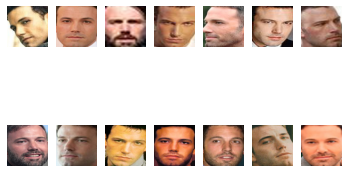

In [4]:
# demonstrate face detection on 5 Celebrity Faces Dataset
from os import listdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN
# specify folder to plot
folder = 'C:/Users/rzouga/Downloads/Github/CNN_CV/Face_Recognition-master/FaceNet/4318_6669_bundle_archive/data/train/ben_afflek/'
i = 1
# enumerate files
for filename in listdir(folder):
	# path
	path = folder + filename
	# get face
	face = extract_face(path)
	print(i, face.shape)
	# plot
	pyplot.subplot(2, 7, i)
	pyplot.axis('off')
	pyplot.imshow(face)
	i += 1
pyplot.show()

Next, we can extend this example to step over each subdirectory for a given dataset (e.g. ‘train‘ or ‘val‘), extract the faces, and prepare a dataset with the name as the output label for each detected face.

The load_faces() function below will load all of the faces into a list for a given directory, e.g. ‘5-celebrity-faces-dataset/train/ben_afflek/‘.

In [5]:
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

We can call the load_faces() function for each subdirectory in the ‘train‘ or ‘val‘ folders. Each face has one label, the name of the celebrity, which we can take from the directory name.

The load_dataset() function below takes a directory name such as ‘5-celebrity-faces-dataset/train/‘ and detects faces for each subdirectory (celebrity), assigning labels to each detected face.

It returns the X and y elements of the dataset as NumPy arrays.

In [6]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

We can then call this function for the ‘train’ and ‘val’ folders to load all of the data, then save the results in a single compressed NumPy array file via the savez_compressed() function.

In [10]:
# face detection for the 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
 
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array
 
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces
 
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)
# load train dataset
trainX, trainy = load_dataset('C:/Users/rzouga/Downloads/Github/CNN_CV/Face_Recognition-master/FaceNet/4318_6669_bundle_archive/data/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('C:/Users/rzouga/Downloads/Github/CNN_CV/Face_Recognition-master/FaceNet/4318_6669_bundle_archive/data/val/')
# save arrays to one file in compressed format
savez_compressed('C:/Users/rzouga/Downloads/Github/CNN_CV/Face_Recognition-master/FaceNet/5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 14 examples for class: ben_afflek
>loaded 17 examples for class: elton_john
>loaded 21 examples for class: jerry_seinfeld
>loaded 19 examples for class: madonna
>loaded 22 examples for class: mindy_kaling
(93, 160, 160, 3) (93,)
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: jerry_seinfeld
>loaded 5 examples for class: madonna
>loaded 5 examples for class: mindy_kaling


This dataset is ready to be provided to a face detection model.
# Create Face Embeddings

The next step is to create a face embedding.

A face embedding is a vector that represents the features extracted from the face. This can then be compared with the vectors generated for other faces. For example, another vector that is close (by some measure) may be the same person, whereas another vector that is far (by some measure) may be a different person.

The classifier model that we want to develop will take a face embedding as input and predict the identity of the face. The FaceNet model will generate this embedding for a given image of a face.

The FaceNet model can be used as part of the classifier itself, or we can use the FaceNet model to pre-process a face to create a face embedding that can be stored and used as input to our classifier model. This latter approach is preferred as the FaceNet model is both large and slow to create a face embedding.

We can, therefore, pre-compute the face embeddings for all faces in the train and test (formally ‘val‘) sets in our 5 Celebrity Faces Dataset.

First, we can load our detected faces dataset using the load() NumPy function.

In [11]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

# load the face dataset
data = load('C:/Users/rzouga/Downloads/Github/CNN_CV/Face_Recognition-master/FaceNet/5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels) 
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('C:/Users/rzouga/Downloads/Github/CNN_CV/Face_Recognition-master/FaceNet/5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)
(93, 128)
(25, 128)


# Perform Face Classification

In this section, we will develop a model to classify face embeddings as one of the known celebrities in the 5 Celebrity Faces Dataset.
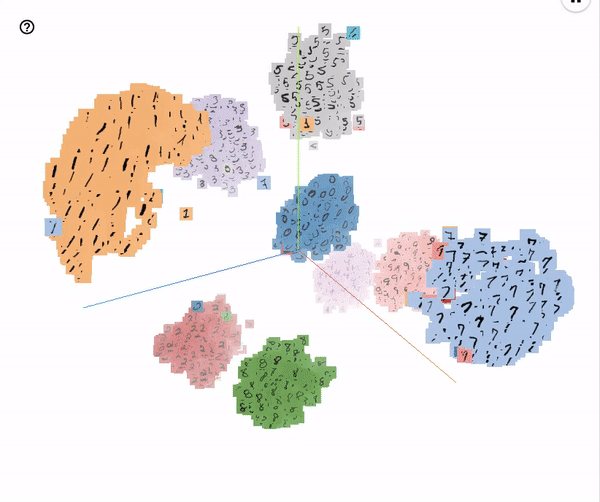

In [22]:
# develop a classifier for the 5 Celebrity Faces Dataset
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
# load dataset
data = load('C:/Users/rzouga/Downloads/Github/CNN_CV/Face_Recognition-master/FaceNet/5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=93, test=25
Accuracy: train=100.000, test=100.000


The complete example for predicting the identity for a given unseen photo in the test dataset is listed below.

Predicted: jerry_seinfeld (87.952)
Expected: jerry_seinfeld


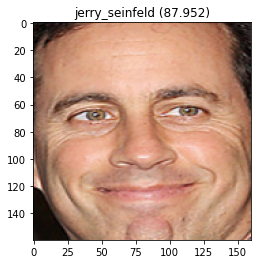

In [47]:
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
data = load('C:/Users/rzouga/Downloads/Github/CNN_CV/Face_Recognition-master/FaceNet/5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

In [ ]:
# Face Regonition
https://medium.com/intro-to-artificial-intelligence/one-shot-learning-explained-using-facenet-dff5ad52bd38
https://blog.engati.com/facial-recognition-systems/
https://github.com/AzureWoods/faceRecognition-yolo-facenet
    https://github.com/hsemarap/who-is-there
https://medium.com/@vinayakvarrier/building-a-real-time-face-recognition-system-using-pre-trained-facenet-model-f1a277a06947
https://medium.com/analytics-vidhya/introduction-to-facenet-a-unified-embedding-for-face-recognition-and-clustering-dbdac8e6f02
https://medium.com/analytics-vidhya/facenet-on-mobile-cb6aebe38505
https://medium.com/analytics-vidhya/facenet-architecture-part-1-a062d5d918a1
https://gist.github.com/milinddeore/0e36ad7dda227f708bef0beb4fe595da
https://towardsdatascience.com/real-time-face-recognition-with-cpu-983d35cc3ec5
https://github.com/vinayakkailas/face_recognition
https://towardsdatascience.com/real-time-face-recognition-with-cpu-983d35cc3ec5
https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/?fbclid=IwAR15h6uxXr8_RzjO3woU0n2oK8KeQuxTzoX-gLmPl30nC4J-6V_Rw2dakQo
https://github.com/iwantooxxoox/Keras-OpenFace
https://openrepository.aut.ac.nz/bitstream/handle/10292/11866/WangH.pdf?sequence=3&isAllowed=y

In [48]:
from keras.models import load_model
import cv2
import numpy as np


path = "C:/PIC/visa.jpg"

faces2=extract_face1(path ,required_size=(160, 160))
embedding = get_embedding(modelFaceNet, faces2) 
# prediction for the face
samples1 = expand_dims(embedding, axis=0)
# normalize input vectors
samples1 = in_encoder.transform(samples1)
yhat_class = model.predict(samples1)
yhat_prob = model.predict_proba(samples1)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
text=  predict_names+class_probability
print(text)
       
# plot for fun
pyplot.imshow("C:/PIC/visa.jpg")
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

C:\Users\rzouga\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


ValueError: not enough values to unpack (expected 3, got 0)